In [1]:
import glob
import xarray as xr
import pandas as pd

In [2]:
files = glob.glob('/glade/u/home/mcowherd/fos-data/snoteldata/*.csv')
#test = xr.open_dataset(files[1])
df = pd.read_csv(files[1])  #.to_dataframe()

In [3]:
pvars = list(df.columns)[0:-1]

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Load the data into a pandas DataFrame

def run_models(df, num_preds, name):
    '''
    df is the input
    df currently comes from the time_series folder, but there is a better way!!! we want to be better at defining if we mean April 1 or the peak water year
    if we mean peak of the water year, does this mean 1 day per year (peak of the basin average) or each pixel's peak? probably peak average across the basin?
    or the total accumulation of snow across the basin, which means each individual square is peak separately. do this fast ish with dask.
    '''
    outputs = []
    data = df
    # Split the data into training and testing sets
    train_data = data[0:86] #.sample(frac=0.8, random_state=1)
    test_data = data[86:] # .drop(train_data.index)
    # Define the input and output variables
    pvars = list(df.columns)[0:-1]
    if len(pvars) >= num_preds:
        input_vars = pvars[0:num_preds]
    output_var = 'maxval_basin' # Basin-wide snow water equivalent

    # Simple models
    # Model 1: All values are equivalent to the basin-wide value
    y_train = np.array(train_data[output_var])
    y_test = np.array(test_data[output_var])
    y_pred = np.full((len(y_test)), y_train.mean())
    outputs.append({'basin':name, 'model':1, 'MSE': mean_squared_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'ytest': y_test, 'ypred':y_pred})

    # Model 2: Linear regression
    X_train = train_data[input_vars].values.reshape((-1, len(input_vars)))
    X_test = test_data[input_vars].values.reshape((-1, len(input_vars)))
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    outputs.append({'model':2, 'MSE': mean_squared_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'ytest': y_test, 'ypred':y_pred})

    # Load the data into a pandas DataFrame
    # Split the data into training and testing sets
    train_data = data.sample(frac=0.8, random_state=1)
    test_data = data.drop(train_data.index)

    # Define the input and output variables
    # Complex models
    # Model 3: K-Nearest Neighbors Regressor
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    outputs.append({'model':3, 'MSE': mean_squared_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'ytest': y_test, 'ypred':y_pred})


    # Model 4: Ridge Regression
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    outputs.append({'model':4, 'MSE': mean_squared_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'ytest': y_test, 'ypred':y_pred})


    # Model 5: Lasso Regression
    lasso = Lasso(alpha=1.0)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    outputs.append({'model':5, 'MSE': mean_squared_error(y_test, y_pred), 'R2':r2_score(y_test, y_pred), 'ytest': y_test, 'ypred':y_pred})

    return {'name':name, 'outputs':outputs, 'preds': [num_preds, len(pvars)], 'pct': num_preds/len(pvars)}




In [5]:
files = glob.glob('/glade/u/home/mcowherd/nh-WRF/time_series/*')
errs= []
all_outs = []
for fn in files:
    data = xr.open_dataset(fn)
    df = data.to_dataframe()
    name = fn.split('/')[-1].split('.nc')[0]
    for num_preds in range(1,35):
        try:
            all_outs.append(run_models(df, num_preds, name))
        except:
            errs.append(fn)
print(len(all_outs))
print(f'missing {len(errs)} basin-model combos')

2105
missing 4457 basin-model combos


In [17]:
for out in all_outs[0:1]:
    outs_df = pd.DataFrame(out['outputs'])
    outs_df['basin'] = outs_df['basin'][0]
    outs_df['preds'] = [out['preds'] for val in outs_df.index]
    outs_df['pct'] = [out['pct'] for val in outs_df.index]

for out in all_outs[1:]:
    tmp1 = pd.DataFrame(out['outputs'])
    tmp1['basin'] = tmp1['basin'][0]
    tmp1['preds'] = [out['preds'] for val in tmp1.index]
    tmp1['pct'] = [out['pct'] for val in tmp1.index]

    outs_df = pd.concat([outs_df,tmp1])
    
outs_grp = outs_df.groupby(['basin','model','pct']).first()
outs_grp['num_preds'] = [val[0] for val in outs_grp.preds]
outs_df['num_preds'] = [val[0] for val in outs_df.preds]
outs_df['err_by_year'] = [(data['ypred'] - data['ytest'])/data['ytest'] for i,data in outs_df.iterrows()]
tmp = outs_df.groupby(['basin','model','num_preds']).mean(['ypred','ytest'])

In [28]:
tmp = tmp.reset_index()

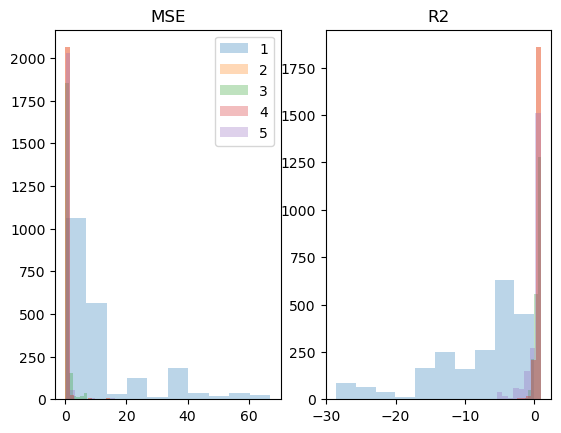

In [30]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,2)
axs[0].set_title('MSE')
axs[1].set_title('R2')
for model in np.unique(tmp['model']):
    data = tmp[tmp.model == model]
    axs[0].hist(data.MSE, alpha = 0.3, label = model)
    axs[1].hist(data.R2, alpha = 0.3, label = model)
axs[0].legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (85,) and (31,)

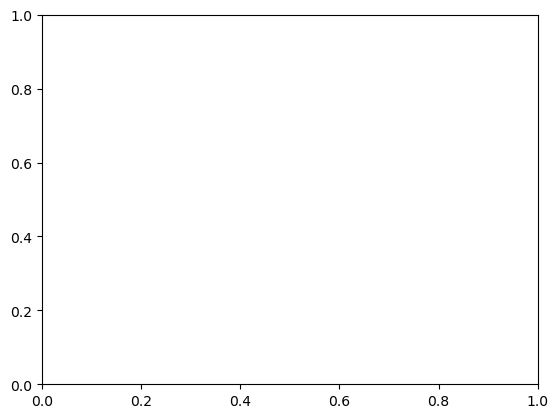

In [31]:
years = range(2015,2100)
fig,ax=plt.subplots()
for mod in np.unique(outs_df.model):
    for n in range(1,max(outs_df.num_preds)):
        data = outs_df[(outs_df.model == mod)]
        arr = np.array(data['err_by_year'].tolist())
        ax.plot(years, np.mean(arr, axis = 0), alpha =0.3)
plt.show()

In [38]:
test = outs_df.loc[0]['err_by_year']

In [40]:
test

0    [0.557027199550357, 0.005052308392268525, 0.27...
0    [0.557027199550357, 0.005052308392268525, 0.27...
0    [0.557027199550357, 0.005052308392268525, 0.27...
0    [0.557027199550357, 0.005052308392268525, 0.27...
0    [0.557027199550357, 0.005052308392268525, 0.27...
                           ...                        
0    [2.504176719906872, 2.454364642600865, 3.16272...
0    [2.504176719906872, 2.454364642600865, 3.16272...
0    [2.504176719906872, 2.454364642600865, 3.16272...
0    [2.504176719906872, 2.454364642600865, 3.16272...
0    [2.504176719906872, 2.454364642600865, 3.16272...
Name: err_by_year, Length: 2105, dtype: object

In [ ]:
# by model
fig,ax=plt.subplots()
for mod in np.unique(outs_df.model):
    ls = []
    for n in range(1,max(outs_df.num_preds)):
        data = outs_df[(outs_df.model == mod) & (outs_df.num_preds == n)]
        ls.append(np.mean(np.array(data['err_by_year'].tolist()),axis=0))
    ax.plot(years, np.mean(np.array(ls), axis = 0), alpha =0.8, label = mod)
ax.legend()
plt.show()

In [ ]:
# by number of predictors
fig,ax=plt.subplots()
for mod in np.unique(outs_df.num_preds):
    ls = []
    for n in range(1,max(outs_df.num_preds)):
        data = outs_df[(outs_df.model == mod) & (outs_df.num_preds == n)]
        ls.append(np.mean(np.array(data['err_by_year'].tolist()),axis=0))
    ax.plot(np.mean(np.array(ls), axis = 0), alpha =0.8, label = mod)
ax.legend()
plt.show()

In [ ]:
fig,ax=plt.subplots()
cb = ax.hexbin(outs_grp.reset_index()['pct'], outs_grp.reset_index()['model'],C = outs_grp.MSE, gridsize = 4, bins = 'log', cmap = 'BrBG')
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(['=basin','linreg', 'KNN', 'ridge', 'lasso'])
ax.set_ylabel('model number')
ax.set_xlabel('pct of stations')
plt.colorbar(cb)
plt.show()
fig,ax=plt.subplots()
cb = ax.hexbin(outs_grp.reset_index()['pct'], outs_grp.reset_index()['model'],C = outs_grp.R2, gridsize = 4, bins = 'log', cmap = 'coolwarm_r')
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(['=basin','linreg', 'KNN', 'ridge', 'lasso'])
ax.set_ylabel('model number')
ax.set_xlabel('pct of stations')
plt.colorbar(cb)
plt.show()

In [ ]:
fig,ax=plt.subplots()
cb = ax.hexbin(outs_grp.reset_index()['num_preds'], outs_grp.reset_index()['model'],C = outs_grp.MSE, gridsize = 4, bins = 'log', cmap = 'BrBG')
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(['=basin','linreg', 'KNN', 'ridge', 'lasso'])
ax.set_ylabel('model number')
ax.set_xlabel('number of predictor stations')
plt.colorbar(cb)
plt.show()
fig,ax=plt.subplots()
cb = ax.hexbin(outs_grp.reset_index()['num_preds'], outs_grp.reset_index()['model'],C = outs_grp.R2, gridsize = 4, bins = 'log', cmap = 'coolwarm_r')
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(['=basin','linreg', 'KNN', 'ridge', 'lasso'])
ax.set_ylabel('model number')
ax.set_xlabel('number of predictor stations')
plt.colorbar(cb)
plt.show()

In [ ]:
import glob
import xarray as xr
folder = '/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new/'
files = glob.glob(folder + '*')

In [ ]:
files


In [ ]:
elev = xr.open_dataset(files[0])
from pydem.dem_processing import DEMProcessor

dem_proc = DEMProcessor(files[0])

mag, aspect = dem_proc.calc_slopes_directions()


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist

# Load DEM grid data using rasterio
dem_arr = elev['HGT']

# Extract slope, aspect, elevation, and radiation factor values using pyDEM
from pydem import slope, aspect, hillshade
slope_arr = slope(dem_arr, 1)
aspect_arr = aspect(dem_arr, 1)
radiation_arr = hillshade(dem_arr, 1)
elevation_arr = dem_arr

# Define lat lon points to compare against the grid
lat_lon_points = [[42.3, -71.1], [42.4, -71.2], [42.5, -71.3],
                  [42.6, -71.4], [42.7, -71.5], [42.8, -71.6], [42.9, -71.7]]

# Calculate similarity metric for each lat lon point
similarity_matrix = np.zeros((len(lat_lon_points), dem_data.width * dem_data.height))

for i, lat_lon in enumerate(lat_lon_points):
    # Convert lat lon to pixel coordinates
    row, col = dem_data.index(lat_lon[1], lat_lon[0])
    
    # Extract slope, aspect, elevation, and radiation factor values for the current point
    slope_val = slope_arr[row, col]
    aspect_val = aspect_arr[row, col]
    radiation_val = radiation_arr[row, col]
    elevation_val = elevation_arr[row, col]
    
    # Calculate Euclidean distance to every point on the grid
    grid_vals = np.stack((slope_arr.ravel(), aspect_arr.ravel(), radiation_arr.ravel(), elevation_arr.ravel()), axis=1)
    point_vals = np.array([slope_val, aspect_val, radiation_val, elevation_val]).reshape(1, -1)
    dist = cdist(point_vals, grid_vals)
    
    # Convert distance to similarity metric using inverse distance weighting
    sim = 1 / (dist + 0.0001) # Add a small value to avoid division by zero
    sim = sim.ravel()
    sim /= np.sum(sim) # Normalize to sum to 1
    similarity_matrix[i, :] = sim

print(similarity_matrix)


In [ ]:
elev